# DCGAN with attribute
## Architecture:
* <b>image size: (H, W): from (218, 178) to (32, 32)</b>
* <b>Generator:</b> 1 FC + 4 deconv layer <br>
    [**(data)**+**(attr)**] 
    -> [FC] -> flatten -> BN1 -> lReLU1  <br>
    ->[Decv2] -> BN2 -> lReLU2 <br>
    ->[Decv3] -> BN3 -> lReLU3 <br>
    ->[Decv4] -> sigmoid<br>
* <b>Discriminator:</b>4 conv layer + 1 FC layer <br>
    [**(data)**] 
    ->[Conv1] -> lReLU1 -> <br>
    ->[Conv2] -> BN2 -> lReLU2 <br>
    ->[Conv3] -> BN3 -> lReLU3 <br>
    ->flatten + **(attr)** -> [FC]<br>

In [36]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.misc
import pandas as pd
import os
import math
%matplotlib inline

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

batchsize = 32
num_of_img = 50000
Z_dim = 100  # noize dim
X_dim = 116412 # 178 * 218 * 3
y_dim = 23 # total attr dim
h_dim = 128 # last FC hidden layer

H_ = 64
W_ = 64 
attr_dim = 5 # desired sample attr dim

### det directory
OUTPUT_DIR = 'o_DCGAN_attr_/' 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data preprocessing
* helper function for risizee image
* load data & attr
* choose choose specific features for observation

In [37]:
def center_crop(x, crop_h, crop_w,
                resize_h, resize_w):
    if crop_w is None:
        crop_w = crop_h
    h, w = x.shape[:2]
    j = int(round((h - crop_h)/2.))
    i = int(round((w - crop_w)/2.))
    return scipy.misc.imresize(
        x[j:j+crop_h, i:i+crop_w], [resize_h, resize_w])

def transform(image, input_height, input_width, 
              resize_height, resize_width, crop=True):
    if crop:
        cropped_image = center_crop(
          image, input_height, input_width, 
          resize_height, resize_width)
    else:
        cropped_image = scipy.misc.imresize(image, [resize_height, resize_width])
#     return np.array(cropped_image)/127.5 - 1.
    return np.array(cropped_image)/255.

In [38]:
def load_train_data():
#     cols = ["Arched_Eyebrows", "Bags_Under_Eyes", "Bangs", "Big_Lips", "Big_Nose", "Black_Hair", "Blond_Hair", "Brown_Hair",
#        "Bushy_Eyebrows","Eyeglasses","Heavy_Makeup","High_Cheekbones","Male", "Mouth_Slightly_Open","Narrow_Eyes",
#        "No_Beard","Oval_Face","Pointy_Nose","Smiling","Straight_Hair","Wavy_Hair","Wearing_Hat","Young"]
    
    cols = ["Black_Hair", "Blond_Hair", "Brown_Hair", "Male", "Smiling"]

    attr = pd.read_csv('data/list_attr_celeba.csv', delim_whitespace=True, skiprows=1, usecols=cols)

    attr = attr.values[:num_of_img]
    print "shape of attr: {}".format(attr.shape)
    print "min of attr: {}".format(np.amin(attr))
    print "max of attr: {}".format(np.amax(attr))
   
    X = []

    for i in range(num_of_img):
        X_ = scipy.misc.imread('data/img_align_celeba/{:06d}.jpg'.format(i + 1))
        X_ = transform(X_, 218, 178, H_, W_, True)
        X_ = X_.reshape(H_ * W_ * 3)
        #X_ = np.concatenate([X_, attr[i]])
        X.append(X_)

    X = np.array(X)
    
   
    #print
    print("shape of one image: {}".format(X[0].shape))
    print("min of one image: {}".format(np.amin(X[0])))
    print("max of one image: {}".format(np.amax(X[0])))
    print("shape of X: {}".format(X.shape))
    
    return X, attr


In [39]:
#####################################################################
###           choose specific features for observation            ###
#####################################################################
# features = [("Arched_Eyebrows", -1), ("Bags_Under_Eyes", -1), ("Bangs", 1), ("Big_Lips", -1), ("Big_Nose", -1),
#             ("Black_Hair", -1), ("Blond_Hair", 1), ("Brown_Hair", -1), ("Bushy_Eyebrows", -1), ("Eyeglasses", -1),
#             ("Heavy_Makeup", -1), ("High_Cheekbones", 1), ("Male", 1), ("Mouth_Slightly_Open", -1), ("Narrow_Eyes", 1),
#             ("No_Beard", -1), ("Oval_Face", 1), ("Pointy_Nose", -1), ("Smiling", 1), 
#             ("Straight_Hair", 1), ("Wavy_Hair", -1), ("Wearing_Hat", -1), ("Young", 1)]
# features = map(lambda x: x[1], features)

features = [1, 0, 0, 1, 0] # Male, 1
# cols = ["Black_Hair", "Blond_Hair", "Brown_Hair", "Male", "Smiling"]

# store sample feature
sample_features = np.array(features).reshape((-1, len(features)))
print(sample_features)
#####################################################################
###                        Load celeb data                        ###
#####################################################################
# (1) reshape date (2) select desired attributes
celeb_data, attr = load_train_data()
celeb_data = celeb_data.reshape((celeb_data.shape[0], H_, W_, 3))

[[1 0 0 1 0]]
shape of attr: (50000, 5)
min of attr: 0
max of attr: 1
shape of one image: (12288,)
min of one image: 0.0
max of one image: 1.0
shape of X: (50000, 12288)


shape of desired_attr: (50000, 5)
(50000, 64, 64, 3)
(50000, 5)
shape of one image: (64, 64, 3)
feature of the image: [0 0 1 0 1]
shape of one image: (64, 64, 3)
feature of the image: [0 0 0 1 0]
shape of one image: (64, 64, 3)
feature of the image: [0 0 1 0 0]


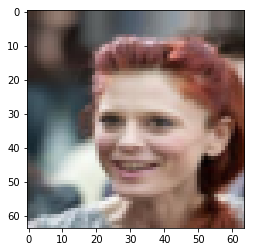

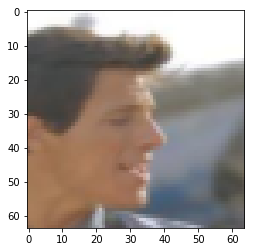

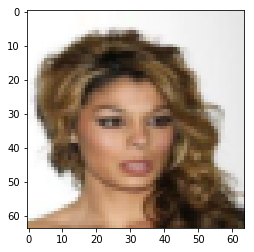

In [47]:
desired_attr = attr # index 12: Male
print "shape of desired_attr: {}".format(desired_attr.shape)

# store training data and attr
train_samples = celeb_data, desired_attr.reshape((-1,desired_attr.shape[1]))

print train_samples[0].shape
print train_samples[1].shape
# check training data and feature
idx = 1
print "shape of one image: {}".format(train_samples[0][idx].shape)
print "feature of the image: {}".format(train_samples[1][idx])
fig = plt.figure()   
plt.imshow(train_samples[0][idx])

idx = 2
print "shape of one image: {}".format(train_samples[0][idx].shape)
print "feature of the image: {}".format(train_samples[1][idx])
fig = plt.figure()   
plt.imshow(train_samples[0][idx])

idx = 5
print "shape of one image: {}".format(train_samples[0][idx].shape)
print "feature of the image: {}".format(train_samples[1][idx])
fig = plt.figure()   
plt.imshow(train_samples[0][idx])


## Implement GAN

* (1) define layer function
* (2) DCGAN

In [48]:
def viz_grid(Xs, padding):
    N, H, W, C = Xs.shape 
    grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size + 1)
    grid_width = W * grid_size + padding * (grid_size + 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = padding, H + padding
    for y in range(grid_size):
        x0, x1 = padding, W + padding
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                grid[y0:y1, x0:x1] = img
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

def conv2d(input, kernel_size, stride, num_filter, name = 'conv2d'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d(input, W, stride_shape, padding = 'SAME') + b

def conv2d_transpose(input, kernel_size, stride, num_filter, name = 'conv2d_transpose'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, num_filter, input.get_shape()[3]]
        output_shape = tf.stack([tf.shape(input)[0], tf.shape(input)[1] * 2, tf.shape(input)[2] * 2, num_filter])

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d_transpose(input, W, output_shape, stride_shape, padding = 'SAME') + b

def fc(input, num_output, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, W) + b

def batch_norm(input, is_training):
    out = tf.contrib.layers.batch_norm(input, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def leaky_relu(input, alpha = 0.2):
    return tf.maximum(alpha * input, input)

In [55]:
class DCGAN(object):

    def __init__(self):
        self.num_epoch = 10
        self.batch_size = batchsize
        self.log_step = 50
        self.visualize_step = 200
        self.code_size = 100 #64
        self.attr_size = attr_dim
        self.learning_rate = 1e-4
        self.vis_learning_rate = 1e-2
        self.recon_steps = 100
        self.actmax_steps = 100
        
        self._dis_called = False
        self._gen_called = False
    
        self.tracked_noise = np.random.normal(0, 1, [64, self.code_size])

        self.real_input = tf.placeholder(tf.float32, [None, H_, W_, 3])
        self.real_label = tf.placeholder(tf.float32, [None, 1])
        self.fake_label = tf.placeholder(tf.float32, [None, 1])
        self.noise = tf.placeholder(tf.float32, [None, self.code_size])
        self.attr = tf.placeholder(tf.float32, [None, self.attr_size])
        self.mismatch_attr = tf.placeholder(tf.float32, [None, self.attr_size])
        
        
        self.is_train = tf.placeholder(tf.bool)
        
        self.recon_sample = tf.placeholder(tf.float32, [1, 32, 32, 3])
        self.actmax_label = tf.placeholder(tf.float32, [1, 1])
        
        with tf.variable_scope('actmax'):
            self.actmax_attr = tf.placeholder(tf.float32, [1, self.attr_size])
#             tf.get_variable('actmax_code', [1, self.attr_size])
            self.actmax_code = tf.get_variable('actmax_code', [1, self.code_size],
                                               initializer = tf.constant_initializer(0.0))
        
        self._init_ops()

    def _discriminator(self, inputs, attr_):
        # We have multiple instances of the discriminator in the same computation graph,
        # so set variable sharing if this is not the first invocation of this function.
        with tf.variable_scope('dis', reuse = self._dis_called):
            self._dis_called = True
            
            attr_ = tf.tile(tf.expand_dims(tf.tile(tf.expand_dims(attr_, 1), [1, H_, 1]), 1), [1, W_, 1, 1])
            print "attr_: {}".format(attr_)
            inputs = tf.concat([inputs, attr_], axis = 3)
            print "inputs: {}".format(inputs)
            dis_conv1 = conv2d(inputs, 4, 2, 32, 'conv1')
#             print dis_conv1.shape
            dis_lrelu1 = leaky_relu(dis_conv1)
            dis_conv2 = conv2d(dis_lrelu1, 4, 2, 64, 'conv2')
#             print dis_conv2.shape
            dis_batchnorm2 = batch_norm(dis_conv2, self.is_train)
            dis_lrelu2 = leaky_relu(dis_batchnorm2)
            dis_conv3 = conv2d(dis_lrelu2, 4, 2, 128, 'conv3')
#             print dis_conv3.shape
            dis_batchnorm3 = batch_norm(dis_conv3, self.is_train)
            dis_lrelu3 = leaky_relu(dis_batchnorm3)
            dis_reshape3 = tf.reshape(dis_lrelu3, [-1, 4 * 4 * 128 * 4])
#             print dis_reshape3.shape
            dis_fc4 = fc(dis_reshape3, 1, 'fc4')
            dis_prob = tf.nn.sigmoid(dis_fc4)
            return tf.reduce_mean(dis_prob), dis_fc4

    def _generator(self, noise, attr_):
        with tf.variable_scope('gen', reuse = self._gen_called):
            self._gen_called = True
            inputs = tf.concat(values = [noise, attr_], axis = 1)
            gen_fc1 = fc(inputs, 4 * 4 * 128 * 4, 'fc1')
            gen_reshape1 = tf.reshape(gen_fc1, [-1, 4 * 2, 4 * 2, 128])
#             print gen_reshape1.shape
            gen_batchnorm1 = batch_norm(gen_reshape1, self.is_train)
            gen_lrelu1 = leaky_relu(gen_batchnorm1)
            gen_conv2 = conv2d_transpose(gen_lrelu1, 4, 2, 64, 'conv2')
#             print gen_conv2.shape
            gen_batchnorm2 = batch_norm(gen_conv2, self.is_train)
            gen_lrelu2 = leaky_relu(gen_batchnorm2)
            gen_conv3 = conv2d_transpose(gen_lrelu2, 4, 2, 32, 'conv3')
#             print gen_conv3.shape
            gen_batchnorm3 = batch_norm(gen_conv3, self.is_train)
            gen_lrelu3 = leaky_relu(gen_batchnorm3)
            gen_conv4 = conv2d_transpose(gen_lrelu3, 4, 2, 3, 'conv4')
#             print gen_conv4.shape
            gen_sigmoid4 = tf.sigmoid(gen_conv4)
            return gen_sigmoid4

    def _loss(self, labels, logits):
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
        return tf.reduce_mean(loss)

    def _reconstruction_loss(self, generated, target):
        loss = tf.nn.l2_loss(generated - target)
        return tf.reduce_mean(loss)
    
    # Define operations
    def _init_ops(self):
        
        self.fake_samples_op = self._generator(self.noise, self.attr)
        self.D_fake_prob, D_fake = self._discriminator(self.fake_samples_op, self.attr)
        self.D_real_prob, D_real = self._discriminator(self.real_input, self.attr)
        self.D_mis_prob, D_mismatch = self._discriminator(self.real_input, self.mismatch_attr)
        
        self.dis_loss_op = self._loss(self.real_label, D_real) + self._loss(self.fake_label, D_fake) + self._loss(self.fake_label, D_mismatch)
        self.gen_loss_op = self._loss(self.real_label, D_fake)
        
        all_vars = tf.trainable_variables()

        d_var = [v for v in all_vars if v.name.startswith('dis')]
        g_var = [v for v in all_vars if v.name.startswith('gen')]
        
        # print the var status to check var
        import tensorflow.contrib.slim as slim
        print("********* d_var ********** ")
        slim.model_analyzer.analyze_vars(d_var, print_info=True)
        print("********* g_var ********** ") 
        slim.model_analyzer.analyze_vars(g_var, print_info=True)

        dis_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.dis_train_op = dis_optimizer.minimize(self.dis_loss_op, var_list = d_var)
        
        gen_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.gen_train_op = gen_optimizer.minimize(self.gen_loss_op, var_list = g_var)
        
#         ##
#         self.actmax_sample_op = self._generator(self.actmax_code, self.actmax_attr)
#         actmax_dis = self._discriminator(self.actmax_sample_op, self.actmax_attr)
#         self.actmax_loss_op = self._loss(self.actmax_label, actmax_dis)

#         actmax_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
#         self.actmax_op = actmax_optimizer.minimize(self.actmax_loss_op, var_list = [self.actmax_code])
        
#         ##
#         self.recon_loss_op = self._reconstruction_loss(self.actmax_sample_op, self.recon_sample)
        
#         recon_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
#         self.reconstruct_op = recon_optimizer.minimize(self.recon_loss_op, var_list = [self.actmax_code])
    
    # Training function
    def train(self, sess, train_samples, sample_features, load_flag = False):
        if not load_flag:
            sess.run(tf.global_variables_initializer())
    
        train_data, train_attr= train_samples
        num_train = train_data.shape[0]
        step = 0
        
        # smooth the loss curve so that it does not fluctuate too much
        smooth_factor = 0.95
        plot_dis_s = 0
        plot_gen_s = 0
        plot_ws = 0
        
        plot_dis_f = 0
        plot_dis_r = 0
        plot_dis_m = 0
        
        dis_losses = []
        fakes = []
        reals = []
        mismatchs = []
        gen_losses = []
        
        import copy
        update_ratio = 2
        gen_loss = 0.0
        dis_loss = 0.0
        for epoch in range(self.num_epoch):
            for i in range(num_train // self.batch_size):
                step += 1

                batch_data = train_data[i * self.batch_size : (i + 1) * self.batch_size]
                batch_attr = train_attr[i * self.batch_size : (i + 1) * self.batch_size]
                noise = np.random.normal(0, 1, [self.batch_size, self.code_size])
                zeros = np.zeros([self.batch_size, 1])
                ones = np.ones([self.batch_size, 1])
                mismatch_attr = copy.deepcopy(batch_attr)
                for i in range(len(mismatch_attr)):
                    """
                    if i == 0:
                        print("before")
                        print(mismatch_attr[i])
                        print(batch_attr[i])
                    """
                    for j in range(len(mismatch_attr[i])):
                        if mismatch_attr[i][j] == 0:
                            mismatch_attr[i][j] = 1
                        else:
                            mismatch_attr[i][j] = 0
                        """
                        if i == 0:
                            print("after")
                            print(mismatch_attr[i])
                            print(batch_attr[i])
                        """
                if batch_attr.shape[0] != self.batch_size:
                    print "Error: attr shape not match: attr shape {}, batch size {}".format(batch_attr.shape, self.batch_size)
                    continue
                dis_feed_dict = {self.real_input: batch_data, 
                                 self.noise: noise, 
                                 self.attr: batch_attr,
                                 self.mismatch_attr: mismatch_attr,
                                 self.real_label: ones, 
                                 self.fake_label: zeros, 
                                 self.is_train:True}
                
        
                
                gen_feed_dict = {self.noise: noise, 
                                 self.attr: batch_attr,
                                 self.real_label: ones, 
                                 self.is_train: True}
                """
                if i % update_ratio == 0:
                    _, dis_loss = sess.run([self.dis_train_op, self.dis_loss_op], feed_dict = dis_feed_dict)
                else:
                    _, gen_loss = sess.run([self.gen_train_op, self.gen_loss_op], feed_dict = gen_feed_dict)
                """
                _, dis_loss, dis_fake, dis_real, dis_mis  = sess.run([self.dis_train_op, self.dis_loss_op, self.D_fake_prob,
                                                                    self.D_real_prob, self.D_mis_prob], feed_dict = dis_feed_dict)
                _, gen_loss = sess.run([self.gen_train_op, self.gen_loss_op], feed_dict = gen_feed_dict)
                
                plot_dis_s = plot_dis_s * smooth_factor + dis_loss * (1 - smooth_factor)
                plot_gen_s = plot_gen_s * smooth_factor + gen_loss * (1 - smooth_factor)
                plot_ws = plot_ws * smooth_factor + (1 - smooth_factor)
                dis_losses.append(plot_dis_s / plot_ws)
                gen_losses.append(plot_gen_s / plot_ws)
                
                plot_dis_f = plot_dis_f * smooth_factor + dis_fake * (1 - smooth_factor)
                plot_dis_r = plot_dis_r * smooth_factor + dis_real * (1 - smooth_factor)
                plot_dis_m = plot_dis_m * smooth_factor + dis_mis * (1 - smooth_factor)
                fakes.append(plot_dis_f / plot_ws)
                reals.append(plot_dis_r / plot_ws)
                mismatchs.append(plot_dis_m / plot_ws)

                if step % self.log_step == 0:
                    print('Iteration {0}: dis loss = {1:.4f}, gen loss = {2:.4f}'.format(step, dis_loss, gen_loss))

            if not os.path.exists(OUTPUT_DIR):
                os.mkdir(OUTPUT_DIR)
                
            filename = OUTPUT_DIR + '%d_%d.png' % (epoch,i)
            
            fig = plt.figure(figsize = (8, 8)) 
            ax1 = plt.subplot(111)
            image = viz_grid(self.generate(self.tracked_noise, sample_features), 1)
            scipy.misc.imsave(filename, image)
            ax1.imshow(image)
            plt.show()

            plt.plot(dis_losses)
            plt.title('discriminator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()
            
            plt.plot(fakes, label="fake", color="blue")
            plt.plot(reals, label="real", color="red")
            plt.plot(mismatchs, label="mismatch", color="green")
            plt.legend(['fake', 'real', 'mismatch'], loc='upper left')
            plt.title('D_fake_real_mis')
            plt.xlabel('iterations')
            plt.ylabel('prob')
            plt.show()

            plt.plot(gen_losses)
            plt.title('generator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()

    # Find the reconstruction of one input sample
    def reconstruct_one_sample(self, sample):
        ##
        code = np.random.random([1, self.code_size])
        actmax_init_val = tf.convert_to_tensor(code, dtype = tf.float32)
        
        sess.run(self.actmax_code.assign(actmax_init_val))
        last_reconstruction = None
        last_loss = None
        for i in range(self.recon_steps):
        
            ##
            recon_feed_dict = {self.recon_sample: sample, 
                               self.is_train: False}
            
            run_ops = [self.recon_loss_op, self.reconstruct_op, self.actmax_sample_op]
            last_loss, _, last_reconstruction = sess.run(run_ops, feed_dict = recon_feed_dict)
        return last_loss, last_reconstruction

    # Find the reconstruction of a batch of samples
    def reconstruct(self, samples):
        reconstructions = np.zeros(samples.shape)
        total_loss = 0
        for i in range(samples.shape[0]):
            loss, reconstructions[i:i+1] = self.reconstruct_one_sample(samples[i:i+1])
            total_loss += loss
        return total_loss / samples.shape[0], reconstructions

    # Generates a single sample from input code
    def generate_one_sample(self, code, attr_):

        gen_vis_feed_dict = {self.noise: code, 
                             self.attr: attr_, 
                             self.is_train: False}
        
        generated = sess.run(self.fake_samples_op, feed_dict = gen_vis_feed_dict)
        return generated

    # Generates samples from input batch of codes
    def generate(self, codes, attr_):
        generated = np.zeros((codes.shape[0], H_, W_, 3))
        for i in range(codes.shape[0]):
            generated[i:i+1] = self.generate_one_sample(codes[i:i+1], attr_)
        return generated

    # Perform activation maximization on one initial code
    def actmax_one_sample(self, initial_code):
        
        ##
        actmax_init_val = tf.convert_to_tensor(initial_code, dtype = tf.float32)
        sess.run(self.actmax_code.assign(actmax_init_val))
        for i in range(self.actmax_steps):
            actmax_feed_dict = {
                self.actmax_label: np.ones([1, 1]),
                self.is_train: False
            }
            _, last_actmax = sess.run([self.actmax_op, self.actmax_sample_op], feed_dict = actmax_feed_dict)
        return last_actmax

    # Perform activation maximization on a batch of different initial codes
    def actmax(self, initial_codes):
        actmax_results = np.zeros((initial_codes.shape[0], 32, 32, 3))
        for i in range(initial_codes.shape[0]):
            actmax_results[i:i+1] = self.actmax_one_sample(initial_codes[i:i+1])
        return actmax_results.clip(0, 1)

## Training
* start to train
* save the trained model at 'model/dcgan' 
* save output image & loss curve at OUTPUT_DIR


attr_: Tensor("dis/Tile_1:0", shape=(?, 64, 64, 5), dtype=float32, device=/device:CPU:0)
inputs: Tensor("dis/concat:0", shape=(?, 64, 64, 8), dtype=float32, device=/device:CPU:0)
attr_: Tensor("dis_1/Tile_1:0", shape=(?, 64, 64, 5), dtype=float32, device=/device:CPU:0)
inputs: Tensor("dis_1/concat:0", shape=(?, 64, 64, 8), dtype=float32, device=/device:CPU:0)
attr_: Tensor("dis_2/Tile_1:0", shape=(?, 64, 64, 5), dtype=float32, device=/device:CPU:0)
inputs: Tensor("dis_2/concat:0", shape=(?, 64, 64, 8), dtype=float32, device=/device:CPU:0)
********* d_var ********** 
---------
Variables: name (type shape) [size]
---------
dis/conv1/w:0 (float32_ref 4x4x8x32) [4096, bytes: 16384]
dis/conv1/b:0 (float32_ref 1x1x1x32) [32, bytes: 128]
dis/conv2/w:0 (float32_ref 4x4x32x64) [32768, bytes: 131072]
dis/conv2/b:0 (float32_ref 1x1x1x64) [64, bytes: 256]
dis/BatchNorm/beta:0 (float32_ref 64) [64, bytes: 256]
dis/BatchNorm/gamma:0 (float32_ref 64) [64, bytes: 256]
dis/conv3/w:0 (float32_ref 4x4x64

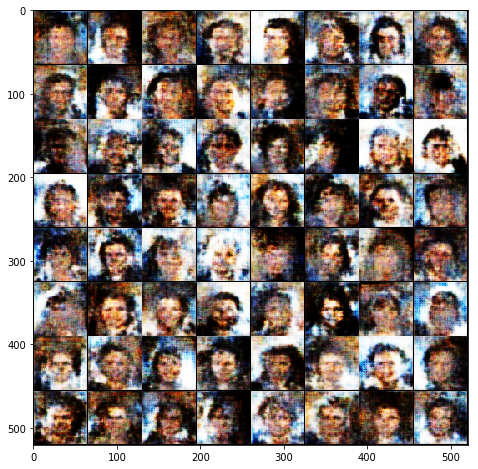

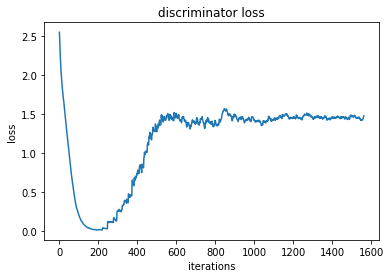

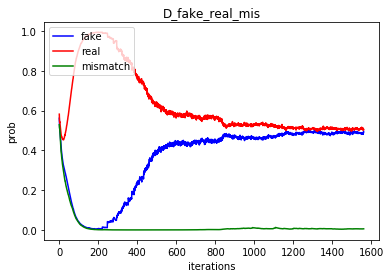

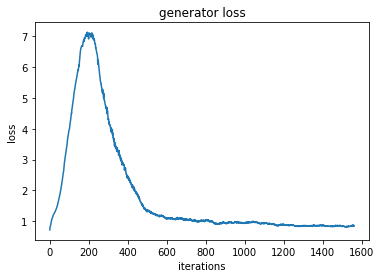

Iteration 1600: dis loss = 1.2419, gen loss = 0.7910
Iteration 1650: dis loss = 1.3554, gen loss = 0.9326
Iteration 1700: dis loss = 1.4902, gen loss = 0.8410
Iteration 1750: dis loss = 1.4160, gen loss = 0.9992
Iteration 1800: dis loss = 1.3885, gen loss = 1.1965
Iteration 1850: dis loss = 1.2696, gen loss = 0.6479
Iteration 1900: dis loss = 1.3365, gen loss = 0.9242
Iteration 1950: dis loss = 1.8941, gen loss = 0.5253
Iteration 2000: dis loss = 1.3080, gen loss = 0.6568
Iteration 2050: dis loss = 1.4620, gen loss = 0.7311
Iteration 2100: dis loss = 1.6254, gen loss = 0.5922
Iteration 2150: dis loss = 1.3009, gen loss = 0.7921
Iteration 2200: dis loss = 1.3504, gen loss = 0.7457
Iteration 2250: dis loss = 1.4076, gen loss = 0.9328
Iteration 2300: dis loss = 1.6647, gen loss = 1.3164
Iteration 2350: dis loss = 1.2940, gen loss = 1.2692
Iteration 2400: dis loss = 1.3692, gen loss = 0.9262
Iteration 2450: dis loss = 1.6342, gen loss = 0.6244
Iteration 2500: dis loss = 1.1496, gen loss = 

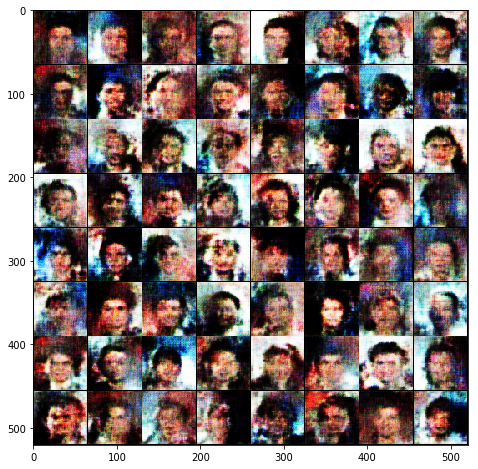

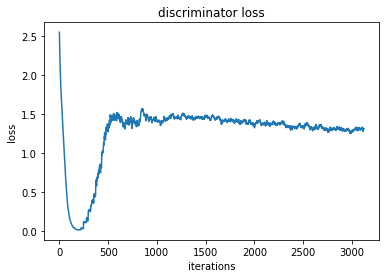

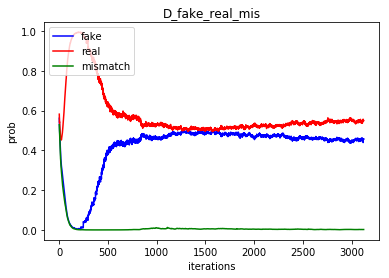

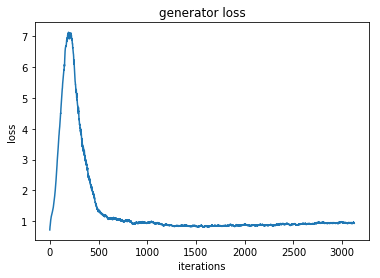

Iteration 3150: dis loss = 1.2944, gen loss = 0.7549
Iteration 3200: dis loss = 1.6275, gen loss = 1.3938
Iteration 3250: dis loss = 1.7516, gen loss = 0.5487
Iteration 3300: dis loss = 1.6022, gen loss = 0.5490
Iteration 3350: dis loss = 1.1678, gen loss = 1.2707
Iteration 3400: dis loss = 1.2832, gen loss = 0.7204
Iteration 3450: dis loss = 1.4722, gen loss = 1.2423
Iteration 3500: dis loss = 1.2539, gen loss = 0.9012
Iteration 3550: dis loss = 1.1817, gen loss = 0.7948
Iteration 3600: dis loss = 1.2363, gen loss = 1.6759
Iteration 3650: dis loss = 1.3351, gen loss = 0.6683
Iteration 3700: dis loss = 1.4615, gen loss = 1.4268
Iteration 3750: dis loss = 1.5257, gen loss = 0.7681
Iteration 3800: dis loss = 1.3326, gen loss = 0.6941
Iteration 3850: dis loss = 1.3374, gen loss = 1.0300
Iteration 3900: dis loss = 1.3914, gen loss = 1.3161
Iteration 3950: dis loss = 1.2453, gen loss = 0.6593
Iteration 4000: dis loss = 1.3567, gen loss = 0.6374
Iteration 4050: dis loss = 1.3813, gen loss = 

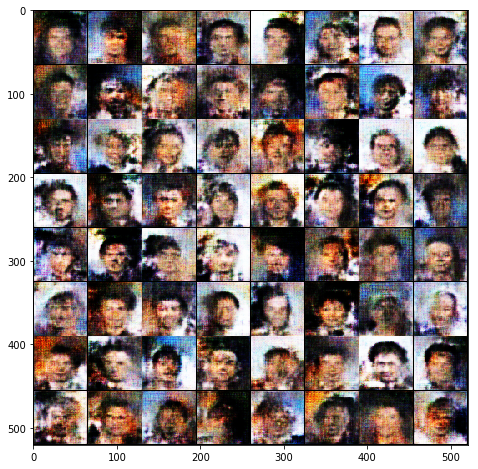

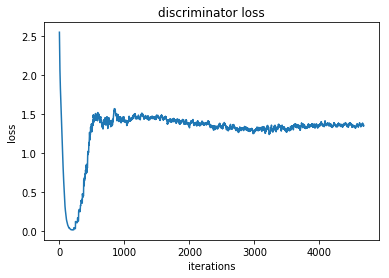

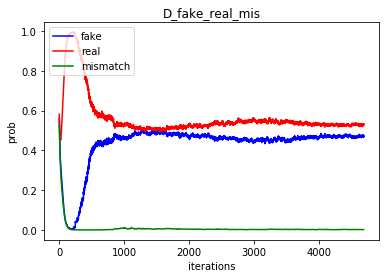

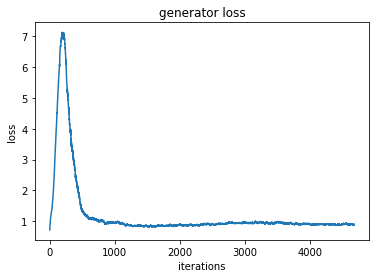

Iteration 4700: dis loss = 1.4032, gen loss = 1.0011
Iteration 4750: dis loss = 1.3526, gen loss = 0.7062
Iteration 4800: dis loss = 1.3563, gen loss = 1.0038
Iteration 4850: dis loss = 1.4357, gen loss = 1.2603
Iteration 4900: dis loss = 1.2499, gen loss = 1.0435
Iteration 4950: dis loss = 1.3377, gen loss = 1.4390
Iteration 5000: dis loss = 1.4755, gen loss = 0.8440
Iteration 5050: dis loss = 1.2967, gen loss = 0.6810
Iteration 5100: dis loss = 1.3328, gen loss = 0.8876
Iteration 5150: dis loss = 1.3290, gen loss = 0.6301
Iteration 5200: dis loss = 1.4809, gen loss = 1.5025
Iteration 5250: dis loss = 1.3477, gen loss = 1.3332
Iteration 5300: dis loss = 1.4297, gen loss = 1.1761
Iteration 5350: dis loss = 1.4388, gen loss = 1.3950
Iteration 5400: dis loss = 1.3311, gen loss = 1.1369
Iteration 5450: dis loss = 1.2855, gen loss = 0.7976
Iteration 5500: dis loss = 1.4717, gen loss = 0.5616
Iteration 5550: dis loss = 1.1883, gen loss = 0.8515
Iteration 5600: dis loss = 1.4172, gen loss = 

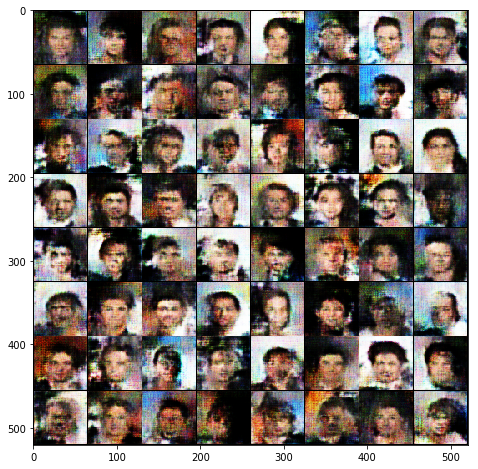

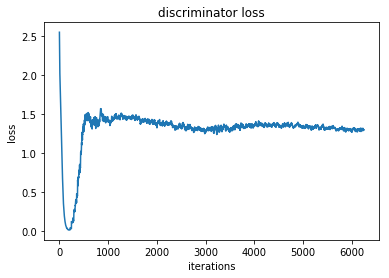

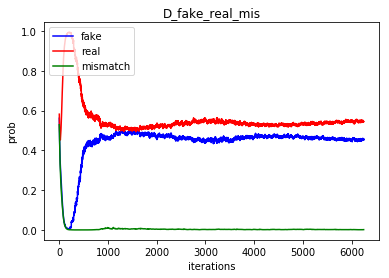

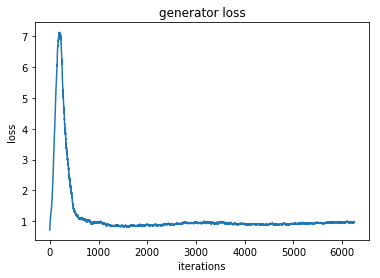

Iteration 6250: dis loss = 1.3271, gen loss = 1.6238
Iteration 6300: dis loss = 1.3235, gen loss = 0.7406
Iteration 6350: dis loss = 1.2263, gen loss = 0.7675
Iteration 6400: dis loss = 1.2734, gen loss = 1.3662
Iteration 6450: dis loss = 1.1794, gen loss = 0.8077
Iteration 6500: dis loss = 1.3883, gen loss = 1.4667
Iteration 6550: dis loss = 1.2259, gen loss = 0.7823
Iteration 6600: dis loss = 1.1667, gen loss = 1.1503
Iteration 6650: dis loss = 1.5423, gen loss = 1.5394
Iteration 6700: dis loss = 1.3570, gen loss = 0.6832
Iteration 6750: dis loss = 1.3117, gen loss = 0.7172
Iteration 6800: dis loss = 1.1539, gen loss = 0.9853
Iteration 6850: dis loss = 1.3309, gen loss = 0.5992
Iteration 6900: dis loss = 1.2089, gen loss = 0.7982
Iteration 6950: dis loss = 1.3544, gen loss = 0.6611
Iteration 7000: dis loss = 1.4635, gen loss = 1.1702
Iteration 7050: dis loss = 1.1185, gen loss = 1.3193
Iteration 7100: dis loss = 1.1814, gen loss = 0.9603
Iteration 7150: dis loss = 1.2766, gen loss = 

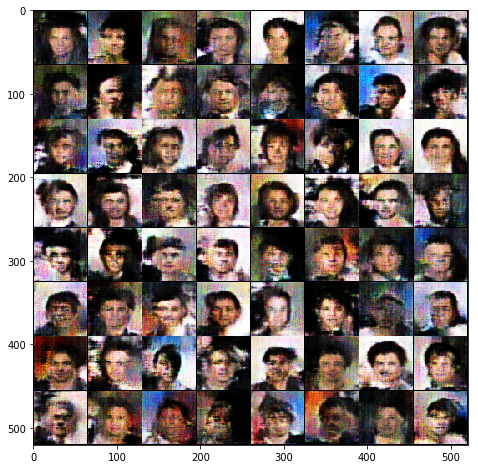

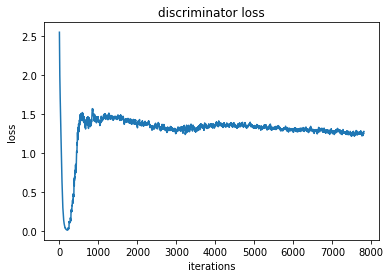

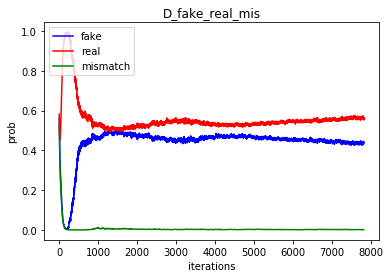

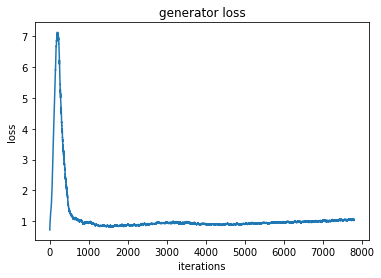

Iteration 7850: dis loss = 1.1114, gen loss = 1.5269
Iteration 7900: dis loss = 1.0728, gen loss = 0.7819
Iteration 7950: dis loss = 1.1452, gen loss = 1.4337
Iteration 8000: dis loss = 1.3587, gen loss = 1.5079
Iteration 8050: dis loss = 1.2612, gen loss = 0.9124
Iteration 8100: dis loss = 1.4022, gen loss = 0.7503
Iteration 8150: dis loss = 1.2479, gen loss = 1.8770
Iteration 8200: dis loss = 1.2388, gen loss = 0.7664
Iteration 8250: dis loss = 1.2296, gen loss = 1.6691
Iteration 8300: dis loss = 1.1939, gen loss = 0.6461
Iteration 8350: dis loss = 1.2878, gen loss = 0.5986
Iteration 8400: dis loss = 1.1264, gen loss = 0.9108
Iteration 8450: dis loss = 1.0870, gen loss = 0.7577
Iteration 8500: dis loss = 1.1364, gen loss = 0.5254
Iteration 8550: dis loss = 1.2398, gen loss = 1.2405
Iteration 8600: dis loss = 1.4329, gen loss = 1.5278
Iteration 8650: dis loss = 1.2146, gen loss = 1.0642
Iteration 8700: dis loss = 1.1716, gen loss = 0.7713
Iteration 8750: dis loss = 1.1140, gen loss = 

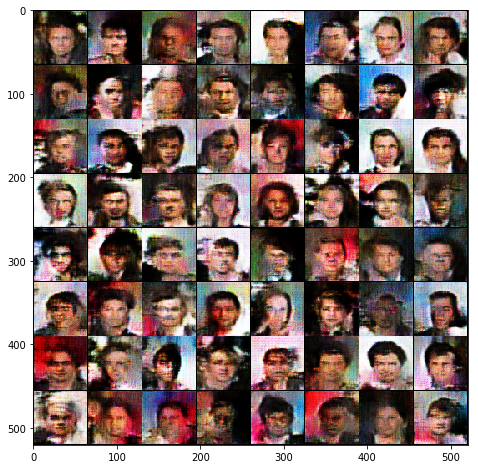

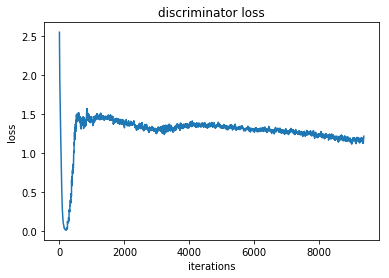

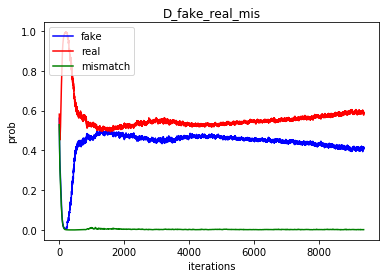

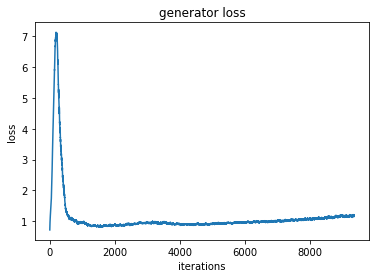

Iteration 9400: dis loss = 1.1847, gen loss = 1.0969
Iteration 9450: dis loss = 1.1462, gen loss = 1.4649
Iteration 9500: dis loss = 1.1068, gen loss = 0.8268
Iteration 9550: dis loss = 1.1771, gen loss = 1.3168
Iteration 9600: dis loss = 1.2857, gen loss = 0.5617
Iteration 9650: dis loss = 1.1735, gen loss = 1.6443
Iteration 9700: dis loss = 1.2630, gen loss = 1.6668
Iteration 9750: dis loss = 1.2122, gen loss = 0.5996
Iteration 9800: dis loss = 1.4252, gen loss = 0.5144
Iteration 9850: dis loss = 1.2603, gen loss = 2.0965
Iteration 9900: dis loss = 1.1440, gen loss = 1.4718
Iteration 9950: dis loss = 1.0540, gen loss = 1.5737
Iteration 10000: dis loss = 1.1065, gen loss = 1.5161
Iteration 10050: dis loss = 0.9586, gen loss = 0.8159
Iteration 10100: dis loss = 1.0180, gen loss = 1.1348
Iteration 10150: dis loss = 1.0542, gen loss = 1.5432
Iteration 10200: dis loss = 1.2752, gen loss = 1.8018
Iteration 10250: dis loss = 0.9095, gen loss = 1.3439
Iteration 10300: dis loss = 1.0457, gen 

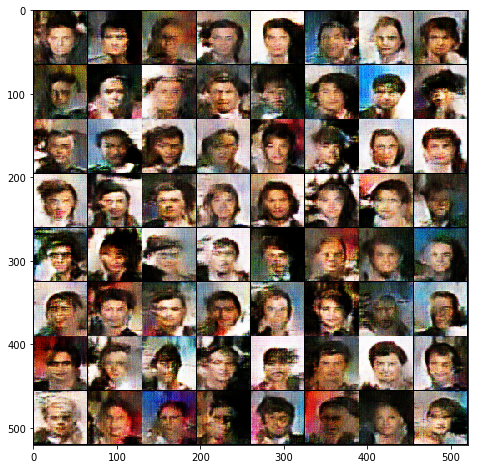

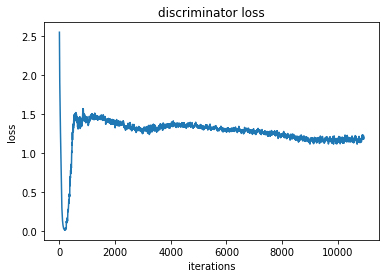

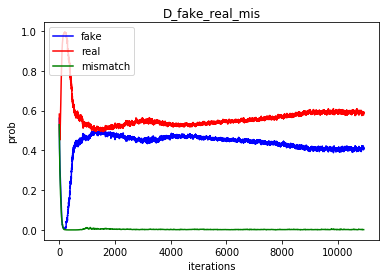

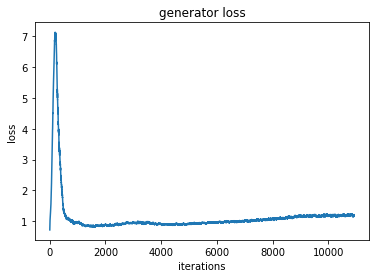

Iteration 10950: dis loss = 1.3176, gen loss = 1.0601
Iteration 11000: dis loss = 1.1943, gen loss = 0.6601
Iteration 11050: dis loss = 1.1141, gen loss = 1.7631
Iteration 11100: dis loss = 1.2042, gen loss = 0.5702
Iteration 11150: dis loss = 1.0319, gen loss = 1.4943
Iteration 11200: dis loss = 1.2869, gen loss = 1.4432
Iteration 11250: dis loss = 0.8969, gen loss = 1.1859
Iteration 11300: dis loss = 0.8374, gen loss = 0.8060
Iteration 11350: dis loss = 1.0200, gen loss = 0.6802
Iteration 11400: dis loss = 1.0087, gen loss = 0.8532
Iteration 11450: dis loss = 1.0652, gen loss = 1.9128
Iteration 11500: dis loss = 1.3243, gen loss = 2.2316
Iteration 11550: dis loss = 1.3584, gen loss = 0.6711
Iteration 11600: dis loss = 1.1849, gen loss = 0.5359
Iteration 11650: dis loss = 1.3606, gen loss = 0.6084
Iteration 11700: dis loss = 1.0546, gen loss = 1.5393
Iteration 11750: dis loss = 1.2111, gen loss = 1.7943
Iteration 11800: dis loss = 1.0703, gen loss = 0.7597
Iteration 11850: dis loss = 

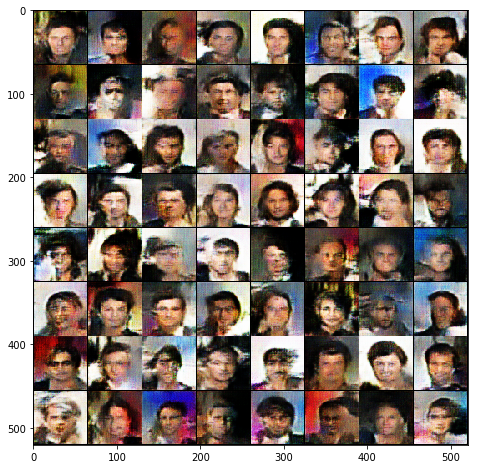

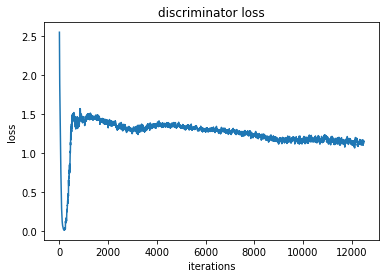

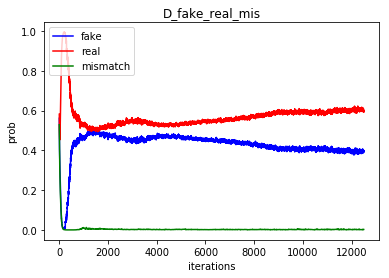

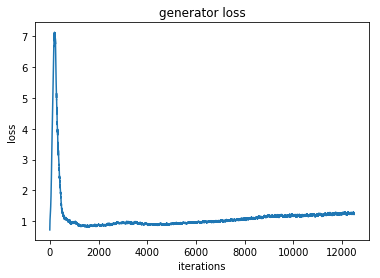

Iteration 12500: dis loss = 0.9989, gen loss = 0.9450
Iteration 12550: dis loss = 0.9599, gen loss = 1.0547
Iteration 12600: dis loss = 0.9104, gen loss = 1.2432
Iteration 12650: dis loss = 1.1604, gen loss = 0.7414
Iteration 12700: dis loss = 1.0350, gen loss = 1.6673
Iteration 12750: dis loss = 1.1757, gen loss = 0.5726
Iteration 12800: dis loss = 1.0618, gen loss = 0.8277
Iteration 12850: dis loss = 0.9505, gen loss = 0.8162
Iteration 12900: dis loss = 1.2272, gen loss = 2.3696
Iteration 12950: dis loss = 0.9989, gen loss = 0.6898
Iteration 13000: dis loss = 1.1644, gen loss = 0.5554
Iteration 13050: dis loss = 1.5392, gen loss = 1.9687
Iteration 13100: dis loss = 1.1847, gen loss = 0.9649
Iteration 13150: dis loss = 1.2276, gen loss = 0.5043
Iteration 13200: dis loss = 1.4056, gen loss = 0.6042
Iteration 13250: dis loss = 0.8803, gen loss = 1.3486
Iteration 13300: dis loss = 0.9466, gen loss = 0.8688
Iteration 13350: dis loss = 1.0761, gen loss = 0.5988
Iteration 13400: dis loss = 

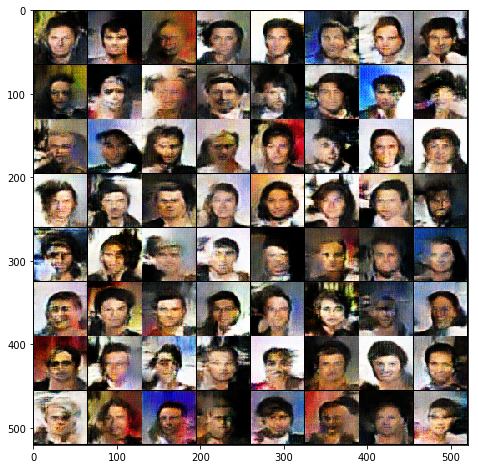

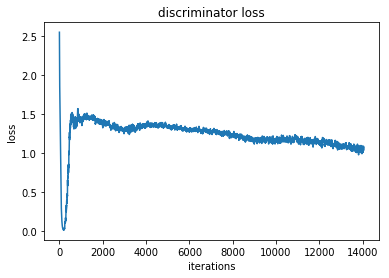

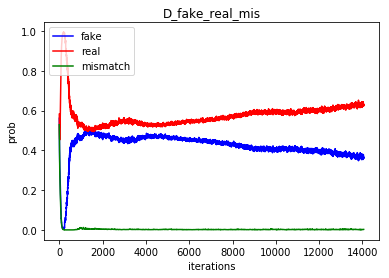

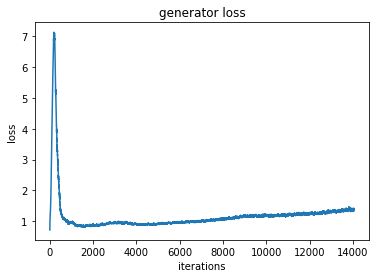

Iteration 14100: dis loss = 1.0286, gen loss = 1.4690
Iteration 14150: dis loss = 1.0664, gen loss = 1.3121
Iteration 14200: dis loss = 0.9094, gen loss = 1.0864
Iteration 14250: dis loss = 1.0386, gen loss = 0.7449
Iteration 14300: dis loss = 1.1734, gen loss = 1.9629
Iteration 14350: dis loss = 1.3205, gen loss = 1.9432
Iteration 14400: dis loss = 0.8490, gen loss = 1.5681
Iteration 14450: dis loss = 1.1250, gen loss = 0.9759
Iteration 14500: dis loss = 1.0033, gen loss = 0.9686
Iteration 14550: dis loss = 1.1850, gen loss = 0.7037
Iteration 14600: dis loss = 0.7710, gen loss = 1.3849
Iteration 14650: dis loss = 1.0012, gen loss = 1.9808
Iteration 14700: dis loss = 0.9990, gen loss = 1.9882
Iteration 14750: dis loss = 1.1577, gen loss = 0.7942
Iteration 14800: dis loss = 0.8572, gen loss = 1.8745
Iteration 14850: dis loss = 0.8540, gen loss = 1.7255
Iteration 14900: dis loss = 1.0813, gen loss = 0.9413
Iteration 14950: dis loss = 0.9471, gen loss = 1.3683
Iteration 15000: dis loss = 

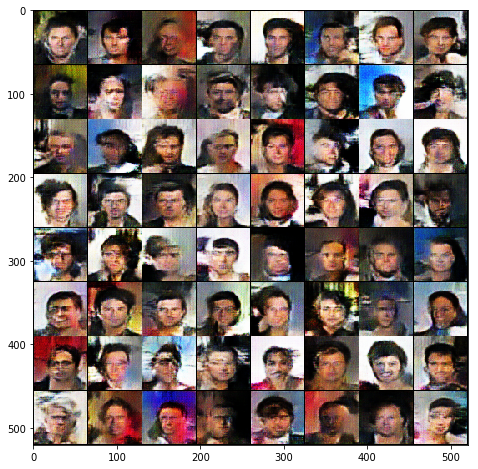

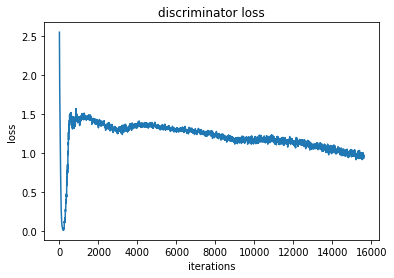

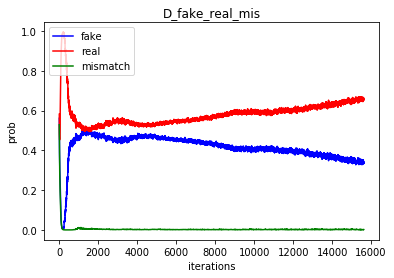

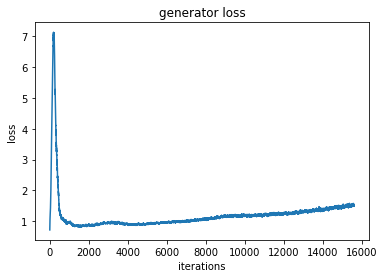

In [56]:
tf.reset_default_graph()

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dcgan.train(sess, train_samples, sample_features)
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.save(sess, 'model/dcgan')
